<a href="https://colab.research.google.com/github/CeciSC/LSTMEquityIndexPrediction/blob/main/sp500_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Add S&P 500 and HS300

In [ ]:
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

print(tf.__version__)


2.3.0


In [ ]:
from keras.layers import Input, Dense, LSTM
from keras.models import Model
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving sp500.csv to sp500.csv


# New Section

In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.StringIO(uploaded['sp500.csv'].decode('utf-8')))
df

,Date,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,1132.989990,1116.560059,1133.869995,1116.560059,3991400000,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1670751798,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1/5/10,1136.520020,1132.660034,1136.630005,1129.660034,2491020000,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1680495719,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1/6/10,1137.140015,1135.709961,1139.189941,1133.949951,4972660000,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1689649585,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1/7/10,1141.689941,1136.270020,1142.459961,1131.319946,5270680000,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1700117112,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1/8/10,1144.979980,1140.520020,1145.390015,1136.219971,4389590000,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1708729171,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,12/23/19,3224.010010,3226.050049,3227.780029,3222.300049,3060610000,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2825748610,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466
2511,12/24/19,3223.379883,3225.449951,3226.429932,3220.510010,1296540000,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2824040676,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817
2512,12/26/19,3239.909912,3227.199951,3240.080078,3227.199951,2160680000,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2827207304,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438
2513,12/27/19,3240.020020,3247.229980,3247.929932,3234.370117,2428670000,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2830565850,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078


In [ ]:
df.dtypes

Date                              object
Close                            float64
Open                             float64
High                             float64
Low                              float64
Volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [ ]:
df[['Volume']] = df[['Volume']].astype('float')
df[['OBV']] = df[['OBV']].astype('float')

# df_feature = df[['Close','Open','High','Low','Volume']]
# df_feature.columns = [['close','open','high','low','volume']]
# df_feature.head()
df_feature = df
df_feature = df_feature.drop(['Date'], axis=1)
df_feature.head()

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.42000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.10000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.10000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.98999,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.52002,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007


In [ ]:
df_feature.shape

(2515, 37)

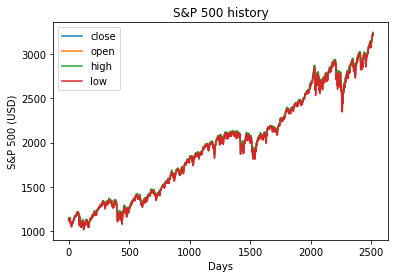

In [ ]:
### EDA
plt.figure()
plt.plot(df_feature[["Close"]])
plt.plot(df_feature[["Open"]])
plt.plot(df_feature[["High"]])
plt.plot(df_feature[["Low"]])
plt.title('S&P 500 history')
plt.ylabel('S&P 500 (USD)')
plt.xlabel('Days')
plt.legend(['close', 'open','high','low'], loc='upper left')
plt.show()

In [ ]:
data_train = df_feature.iloc[:2013, :]
data_test = df_feature.iloc[2013:, :]
print(data_train.shape, data_test.shape)

(2013, 37) (502, 37)


In [ ]:
data_train

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,2683.340088,2684.219971,2685.350098,2678.129883,2.399830e+09,2684.570068,2679.250000,2681.469971,2683.758,2673.356,2653.2325,-0.015575,0.373463,23.898475,2706.536352,2571.141340,76.097626,77.682286,2.056464,14.262857,31.33,54.07,26.735632,61.664899,1.625184,1.111653,68.457544,70.014240,58.333333,2.577371e+09,-0.000458,-0.000328,0.721614,0.000561,0.001527,0.013050,0.011348
2009,2680.500000,2679.090088,2682.739990,2677.959961,1.968780e+09,2683.340088,2684.570068,2679.250000,2681.826,2675.407,2657.1865,-0.049444,0.190364,23.120255,2708.527658,2576.446957,72.837585,76.097626,1.093721,13.147857,-9.66,29.00,33.682495,73.442226,1.517869,1.109328,63.493006,67.778521,50.000000,2.574268e+09,-0.001058,0.000526,0.531386,-0.000720,0.001490,0.010777,0.008774
2010,2682.620117,2682.100098,2685.639893,2678.909912,2.202080e+09,2680.500000,2683.340088,2684.570068,2682.056,2677.258,2659.9655,0.021029,0.200280,22.416176,2709.107277,2583.849646,72.309166,72.837585,0.850755,12.938571,1.15,22.63,28.747672,68.256131,1.322909,1.055992,65.719894,68.595166,50.000000,2.577621e+09,0.000791,0.000194,0.551295,0.000086,0.001046,0.009359,0.008517
2011,2687.540039,2686.100098,2687.659912,2682.689941,2.153330e+09,2682.620117,2680.500000,2683.340088,2683.714,2679.727,2663.0390,0.142564,0.291560,22.001571,2709.516963,2591.547652,74.627173,72.309166,0.879468,12.265714,8.29,23.43,20.736813,1.237113,1.209022,0.989416,70.697667,70.488786,50.000000,2.580581e+09,0.001834,0.000536,0.975881,0.000618,0.001155,0.008928,0.009200


In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(data_train)

# apply transformation to training data
train = scaler.transform(data_train)

# apply same transformation to test data
test = scaler.transform(data_test)

sp_xstd = np.concatenate([train, test], axis=0)

In [ ]:
sp_xstd

array([[0.06620971, 0.0533975 , 0.06072132, ..., 0.68032492, 0.73890377,
        0.73520955],
       [0.06832656, 0.0630668 , 0.06238195, ..., 0.67280415, 0.73934898,
        0.74386377],
       [0.06869836, 0.06489853, 0.06392221, ..., 0.68243685, 0.74330739,
        0.73900921],
       ...,
       [1.32966936, 1.32100345, 1.32798047, ..., 0.68572779, 0.77989024,
        0.75821107],
       [1.32973539, 1.33303307, 1.33270355, ..., 0.67225058, 0.78394371,
        0.75157323],
       [1.31850356, 1.328745  , 1.32848579, ..., 0.66591011, 0.77439877,
        0.71645595]])

In [ ]:
# standardized features 
sp_xstd = pd.DataFrame(sp_xstd)
sp_xstd.columns = df_feature.columns
sp_xstd


,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,0.066210,0.053397,0.060721,0.063074,0.309232,0.055482,0.055482,0.062270,0.057872,0.043192,0.028565,0.660470,0.773519,0.705551,0.006852,0.044371,0.861240,0.796551,0.735018,0.054929,0.676496,0.631811,0.030812,0.046170,0.760158,0.731713,0.696025,0.710894,0.777778,0.007240,0.724982,0.716107,0.949162,0.642676,0.680325,0.738904,0.735210
1,0.068327,0.063067,0.062382,0.070895,0.152825,0.066210,0.055482,0.055482,0.058929,0.045279,0.029521,0.673643,0.774032,0.714415,0.008844,0.043631,0.913615,0.861240,0.795208,0.052773,0.686391,0.674152,0.004973,0.005041,0.764046,0.743170,0.728437,0.734309,0.888889,0.017797,0.611622,0.615709,0.984220,0.651685,0.672804,0.739349,0.743864
2,0.068698,0.064899,0.063922,0.073456,0.411523,0.068327,0.066210,0.055482,0.060252,0.046694,0.030581,0.661870,0.764119,0.720644,0.010379,0.044311,0.920214,0.913615,0.773956,0.047274,0.684485,0.659461,0.084085,0.084085,0.762748,0.757940,0.734555,0.738563,0.888889,0.027715,0.589085,0.596630,0.608792,0.660534,0.682437,0.743307,0.739009
3,0.071427,0.065235,0.065890,0.071886,0.442590,0.068698,0.068327,0.066210,0.062098,0.048145,0.032138,0.672797,0.776593,0.728668,0.012346,0.044578,0.944743,0.920214,0.748063,0.051742,0.701668,0.641562,0.027848,0.027848,0.767326,0.771116,0.780152,0.770210,0.888889,0.039055,0.619387,0.627803,0.930878,0.677940,0.728399,0.751553,0.747803
4,0.073400,0.067787,0.067653,0.074811,0.350741,0.071427,0.068698,0.068327,0.065712,0.049640,0.033672,0.652662,0.781338,0.736747,0.014669,0.044003,0.966264,0.944743,0.745347,0.045290,0.710273,0.639831,0.013407,0.014221,0.777117,0.781523,0.810608,0.792505,0.888889,0.048386,0.609570,0.620172,0.955285,0.736633,0.725989,0.772810,0.751230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,1.320135,1.320313,1.320580,1.320225,0.212202,1.318462,1.308957,1.300423,1.316305,1.307623,1.307867,0.651014,0.786340,1.022114,1.321699,1.300717,0.965569,0.957905,0.784648,0.267146,0.813006,0.842550,0.037073,0.102585,0.786497,0.755214,0.926197,0.923778,0.777778,1.258593,0.591896,0.579834,0.312038,0.662681,0.700807,0.767749,0.748588
2511,1.319757,1.319952,1.319767,1.319156,0.028307,1.320135,1.318462,1.308957,1.320037,1.313192,1.310675,0.633171,0.766273,1.031487,1.327261,1.300141,0.967313,0.965569,0.747342,0.235494,0.747751,0.768434,0.046526,0.120087,0.789144,0.762971,0.914156,0.918046,0.777778,1.256742,0.582587,0.579750,0.484782,0.660168,0.675958,0.768588,0.740537
2512,1.329669,1.321003,1.327980,1.323150,0.118389,1.319757,1.320135,1.318462,1.325935,1.319217,1.313786,0.650725,0.779719,1.050411,1.334064,1.299046,0.985382,0.967313,0.785015,0.237072,0.794954,0.844612,0.002034,0.007069,0.795851,0.775800,0.955986,0.959342,0.888889,1.260173,0.629269,0.620420,0.986788,0.685520,0.685728,0.779890,0.758211
2513,1.329735,1.333033,1.332704,1.327431,0.146325,1.329669,1.319757,1.320135,1.330125,1.323597,1.316489,0.632918,0.765266,1.060184,1.340000,1.298916,0.954123,0.985382,0.773451,0.206436,0.755375,0.821698,0.123017,0.288476,0.802875,0.789246,0.956226,0.959604,0.888889,1.263812,0.584599,0.565734,0.416665,0.665318,0.672251,0.783944,0.751573


In [ ]:
# y train/test: numeric labels, for regression 
y_train = np.array(df_feature.iloc[:2013, 0])
y_test = np.array(df_feature.iloc[2013:, 0])
print(y_train.shape, y_test.shape)

(2013,) (502,)


In [ ]:
test.shape

(502, 37)

# Feature Selection

## SP500

df: variables and label (y)

df_feature: variables

data_train: x training set before standardization

data_test: x testing set before standardization

train: standardized x training set

test: standardized x testing set

y_train: standardized y training set

y_test: standardized y testing set

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [ ]:
df_feature['close_class'] = np.ones((2515,), dtype=int)

# define y labels
for i in range(0, 2514):
  if df_feature.iloc[i+1, 0] > df_feature.iloc[i, 0]:
    df_feature.iloc[i+1, 37] = 1
  else:
    df_feature.iloc[i+1, 37] = 0

In [ ]:
df_feature

,Close,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t),close_class
0,1132.989990,1116.560059,1133.869995,1116.560059,3.991400e+09,1115.100000,1115.100000,1126.420000,1125.698,1121.010,1112.1640,0.647776,1.068679,8.643298,1132.999138,1086.927786,84.870356,78.846150,2.146631,9.192857,6.51,23.81,3.081232,4.616999,1.409173,0.714095,67.244306,63.214617,75.000000,1.670752e+09,0.016043,0.014715,0.949162,0.001158,0.001489,0.013676,0.018726,1
1,1136.520020,1132.660034,1136.630005,1129.660034,2.491020e+09,1132.989990,1115.100000,1115.100000,1127.446,1124.415,1113.6910,0.804828,1.076560,9.350417,1136.160575,1085.757887,89.747808,84.870356,3.689512,9.094286,10.04,40.44,0.497288,0.504125,1.467176,0.827135,70.122163,64.833024,83.333333,1.680496e+09,0.003116,0.003408,0.984220,0.001553,0.001373,0.013741,0.020499,1
2,1137.140015,1135.709961,1139.189941,1133.949951,4.972660e+09,1136.520020,1132.989990,1115.100000,1129.634,1126.724,1115.3855,0.664463,0.924450,9.847328,1138.597668,1086.832332,90.362361,89.747808,3.144757,8.842857,9.36,34.67,8.408532,8.408532,1.447810,0.972874,70.665365,65.126998,83.333333,1.689650e+09,0.000546,0.001259,0.608792,0.001941,0.001522,0.014315,0.019504,1
3,1141.689941,1136.270020,1142.459961,1131.319946,5.270680e+09,1137.140015,1136.520020,1132.989990,1132.688,1129.091,1117.8730,0.794747,1.115853,10.487389,1141.719120,1087.253957,92.646638,90.362361,2.481038,9.047143,15.49,27.64,2.784810,2.784810,1.516096,1.102875,74.713876,67.314440,83.333333,1.700117e+09,0.004001,0.004770,0.930878,0.002704,0.002230,0.015513,0.021306,1
4,1144.979980,1140.520020,1145.390015,1136.219971,4.389590e+09,1141.689941,1137.140015,1136.520020,1138.664,1131.530,1120.3245,0.554685,1.188656,11.131796,1145.406723,1086.344816,94.650843,92.646638,2.411406,8.752143,18.56,26.96,1.340746,1.422130,1.662139,1.205562,77.418091,68.855440,83.333333,1.708729e+09,0.002882,0.003910,0.955285,0.005276,0.002193,0.018599,0.022007,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,3224.010010,3226.050049,3227.780029,3222.300049,3.060610e+09,3221.219971,3205.370117,3191.139893,3206.852,3183.723,3156.2565,0.535042,1.265405,33.895614,3220.180785,3072.903061,94.586116,93.872407,3.418842,18.895714,55.21,106.58,3.707346,10.258503,1.802058,0.945974,87.681299,77.928883,75.000000,2.825749e+09,0.000866,-0.000632,0.312038,0.002035,0.001805,0.017864,0.021466,1
2511,3223.379883,3225.449951,3226.429932,3220.510010,1.296540e+09,3224.010010,3221.219971,3205.370117,3213.024,3192.809,3160.7435,0.322313,0.957495,34.643268,3229.009425,3071.991344,94.748524,94.586116,2.462563,17.448571,31.93,77.47,4.652638,12.008734,1.841543,1.022514,86.612135,77.532657,75.000000,2.824041e+09,-0.000195,-0.000642,0.484782,0.001925,0.001422,0.017986,0.019817,0
2512,3239.909912,3227.199951,3240.080078,3227.199951,2.160680e+09,3223.379883,3224.010010,3221.219971,3222.778,3202.637,3165.7130,0.531591,1.163822,36.152876,3239.808064,3070.260398,96.431209,94.748524,3.428230,17.520714,48.77,107.39,0.203422,0.706861,1.941590,1.149095,90.326191,80.387020,83.333333,2.827207e+09,0.005128,0.003938,0.986788,0.003036,0.001572,0.019627,0.023438,1
2513,3240.020020,3247.229980,3247.929932,3234.370117,2.428670e+09,3239.909912,3223.379883,3224.010010,3229.708,3209.782,3170.0325,0.319286,0.942058,36.932393,3249.230816,3070.056107,93.520236,96.431209,3.131814,16.120000,34.65,98.39,12.301711,28.847557,2.046353,1.281760,90.347574,80.405092,83.333333,2.830566e+09,0.000034,-0.002220,0.416665,0.002150,0.001364,0.020215,0.022078,1


In [ ]:
sp_xstd.drop('Close', axis=1, inplace=True)

In [ ]:
# Use sp_xstd as the standardized x set, df_feature['close_class'] as y


In [ ]:
xx = sp_xstd.describe().transpose().round(3).astype('str')
xx = xx[['count','mean','std','min','max']]
xx

,count,mean,std,min,max
Open,2515.0,0.561,0.354,0.0,1.333
High,2515.0,0.564,0.355,0.0,1.333
Low,2515.0,0.562,0.351,0.0,1.327
Volume,2515.0,0.28,0.085,0.0,1.0
x(t-1),2515.0,0.563,0.353,0.0,1.33
x(t-2),2515.0,0.562,0.353,0.0,1.33
x(t-3),2515.0,0.562,0.352,0.0,1.32
MA5,2515.0,0.563,0.355,0.0,1.33
MA10,2515.0,0.556,0.36,0.0,1.327
MA20,2515.0,0.556,0.366,0.0,1.319


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65288 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65289 missing from current font.
  font.set_text(s, 0, flags=flags)


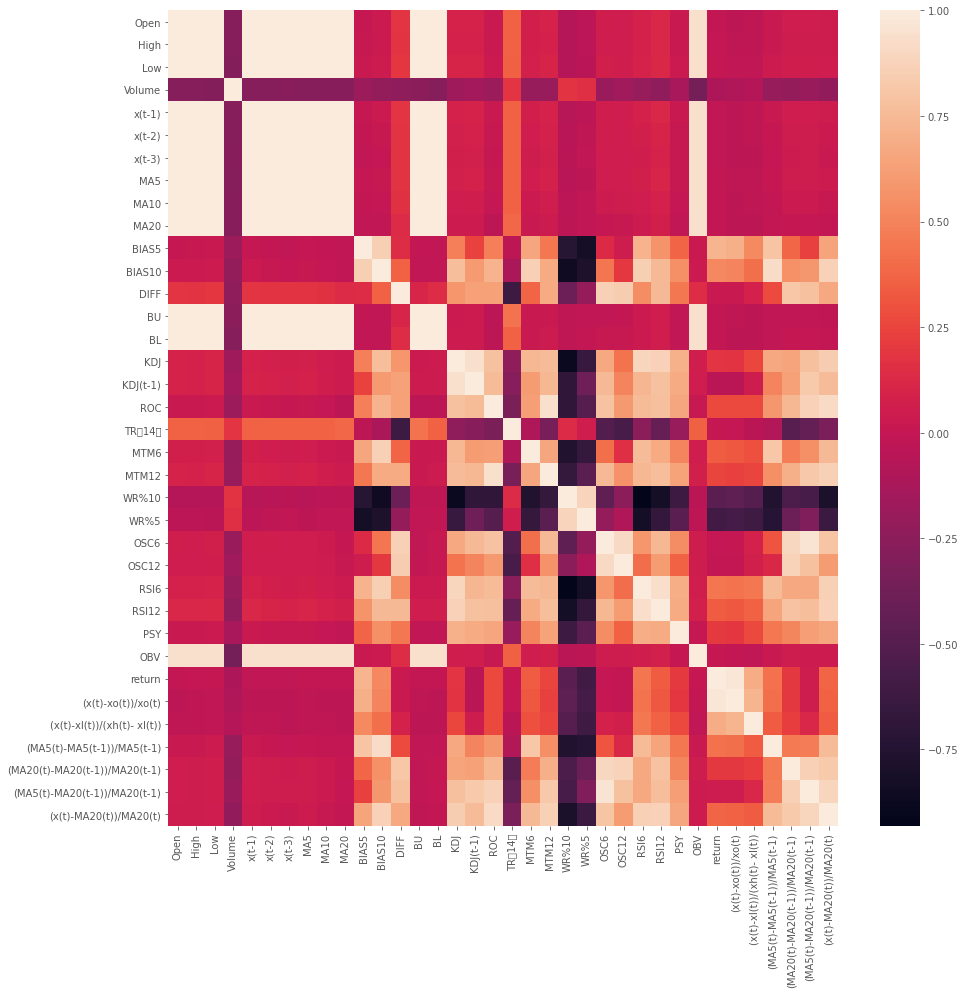

In [ ]:
# Correlation between variables

corr_map = sp_xstd.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_map)
plt.savefig('heatmap_sp.png')

In [ ]:
# dismiss the first line data
df_f = df_feature.iloc[1:, :]

In [ ]:
# the mean is 0.548, which means the move of the stock index price is quite random and makes sense
df_f['close_class'].mean()

0.5481304693715194

In [ ]:
y = df_f['close_class']
y

1       1
2       1
3       1
4       1
5       1
       ..
2510    1
2511    0
2512    1
2513    1
2514    0
Name: close_class, Length: 2514, dtype: int64

## Pearson correlation

In [ ]:
feature_name = sp_xstd.columns.tolist()

In [ ]:
sp_x = sp_xstd.iloc[1:, :]

In [ ]:
cor_list = []
for i in feature_name:
  cor = np.corrcoef(sp_x[i], y)[0, 1]
  cor_list.append(cor)

# replace NaN with 0
cor_list = [0 if np.isnan(i) else i for i in cor_list]


In [ ]:
np.abs(cor_list)

array([0.00609154, 0.00179409, 0.00466618, 0.05386808, 0.00911858,
       0.00816844, 0.00808796, 0.00437853, 0.00575533, 0.00608799,
       0.49901639, 0.3718504 , 0.02647849, 0.00440886, 0.00754714,
       0.1797681 , 0.02232609, 0.19654876, 0.00376922, 0.25650574,
       0.18684128, 0.4291731 , 0.55111961, 0.01587342, 0.00149781,
       0.41546951, 0.29812628, 0.31103651, 0.00553865, 0.68668265,
       0.6537349 , 0.64836419, 0.30547539, 0.14763681, 0.04821639,
       0.27251036])

In [ ]:
sp_x.columns

Index(['Open', 'High', 'Low', 'Volume', 'x(t-1)', 'x(t-2)', 'x(t-3)', 'MA5',
       'MA10', 'MA20', 'BIAS5', 'BIAS10', 'DIFF', 'BU', 'BL', 'KDJ',
       'KDJ(t-1)', 'ROC', 'TR（14）', 'MTM6', 'MTM12', 'WR%10', 'WR%5', 'OSC6',
       'OSC12', 'RSI6', 'RSI12', 'PSY', 'OBV', 'return', '(x(t)-xo(t))/xo(t)',
       '(x(t)-xl(t))/(xh(t)- xl(t))', '(MA5(t)-MA5(t-1))/MA5(t-1)',
       '(MA20(t)-MA20(t-1))/MA20(t-1)', '(MA5(t)-MA20(t-1))/MA20(t-1)',
       '(x(t)-MA20(t))/MA20(t)'],
      dtype='object')

In [ ]:
# Sorted most correlated variables 
fea1 = sp_x.iloc[:,np.argsort(np.abs(cor_list))[-36:]].columns.tolist()
fea1
# If only select those no less than 0.30, then '(MA5(t)-MA5(t-1))/MA5(t-1)', in total 18 variables.

['OSC12',
 'High',
 'TR（14）',
 'MA5',
 'BU',
 'Low',
 'OBV',
 'MA10',
 'MA20',
 'Open',
 'BL',
 'x(t-3)',
 'x(t-2)',
 'x(t-1)',
 'OSC6',
 'KDJ(t-1)',
 'DIFF',
 '(MA5(t)-MA20(t-1))/MA20(t-1)',
 'Volume',
 '(MA20(t)-MA20(t-1))/MA20(t-1)',
 'KDJ',
 'MTM12',
 'ROC',
 'MTM6',
 '(x(t)-MA20(t))/MA20(t)',
 'RSI12',
 '(MA5(t)-MA5(t-1))/MA5(t-1)',
 'PSY',
 'BIAS10',
 'RSI6',
 'WR%10',
 'BIAS5',
 'WR%5',
 '(x(t)-xl(t))/(xh(t)- xl(t))',
 '(x(t)-xo(t))/xo(t)',
 'return']

In [ ]:
fea1[:20]

['OSC12',
 'High',
 'TR（14）',
 'MA5',
 'BU',
 'Low',
 'OBV',
 'MA10',
 'MA20',
 'Open',
 'BL',
 'x(t-3)',
 'x(t-2)',
 'x(t-1)',
 'OSC6',
 'KDJ(t-1)',
 'DIFF',
 '(MA5(t)-MA20(t-1))/MA20(t-1)',
 'Volume',
 '(MA20(t)-MA20(t-1))/MA20(t-1)']

## RFE

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

lr = LogisticRegression(max_iter=1000)
lr.fit(sp_x, y)
predictions = lr.predict(sp_x)
# baseline score
print('AUC score is ', roc_auc_score(y, predictions))
# matrix = confusion_matrix(y, predictions)
# print('FDR is', matrix[1,1]/label['Fraud'].sum())

AUC score is  0.889117086408144


In [ ]:
import warnings
rfecv = RFECV(estimator = lr, step=1, cv=3, verbose=3,n_jobs=1, scoring='roc_auc')
rfecv.fit(sp_x, y)

Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 fea

RFECV(cv=3,
      estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                   fit_intercept=True, intercept_scaling=1,
                                   l1_ratio=None, max_iter=1000,
                                   multi_class='auto', n_jobs=None,
                                   penalty='l2', random_state=None,
                                   solver='lbfgs', tol=0.0001, verbose=0,
                                   warm_start=False),
      min_features_to_select=1, n_jobs=1, scoring='roc_auc', step=1, verbose=3)

In [ ]:
# rank the selected variables
sel1 = pd.DataFrame(sorted(zip(map(lambda x: round(x),rfecv.ranking_),sp_x.columns)),\
                    columns = ['ranking', 'variable'])
sel1

,ranking,variable
0,1,return
1,2,(x(t)-xo(t))/xo(t)
2,3,RSI6
3,4,KDJ(t-1)
4,5,PSY
5,6,(x(t)-xl(t))/(xh(t)- xl(t))
6,7,WR%10
7,8,KDJ
8,9,WR%5
9,10,(MA5(t)-MA5(t-1))/MA5(t-1)


Text(0, 0.5, 'Cross validation score (nb of correct classifications)')

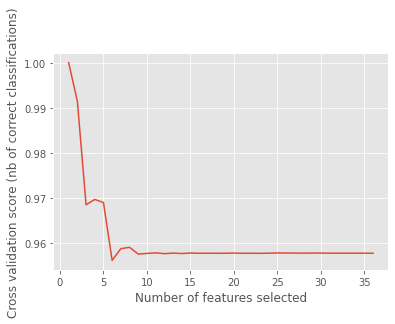

In [ ]:
plt.style.use('ggplot')
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classifications)')
# plt.savefig('score1.png')

In [ ]:
sel1 = sel1[sel1['ranking']<=15]
a = sel1.variable.tolist()
fea2 = sp_x[a]

In [ ]:
lr.fit(fea2, y)
predictions = lr.predict(fea2)
# baseline score
print('AUC score is ', roc_auc_score(y, predictions))

# the AUC rised

AUC score is  0.8902829166581492


In [ ]:
sp_x

,Open,High,Low,Volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
1,0.063067,0.062382,0.070895,0.152825,0.066210,0.055482,0.055482,0.058929,0.045279,0.029521,0.673643,0.774032,0.714415,0.008844,0.043631,0.913615,0.861240,0.795208,0.052773,0.686391,0.674152,0.004973,0.005041,0.764046,0.743170,0.728437,0.734309,0.888889,0.017797,0.611622,0.615709,0.984220,0.651685,0.672804,0.739349,0.743864
2,0.064899,0.063922,0.073456,0.411523,0.068327,0.066210,0.055482,0.060252,0.046694,0.030581,0.661870,0.764119,0.720644,0.010379,0.044311,0.920214,0.913615,0.773956,0.047274,0.684485,0.659461,0.084085,0.084085,0.762748,0.757940,0.734555,0.738563,0.888889,0.027715,0.589085,0.596630,0.608792,0.660534,0.682437,0.743307,0.739009
3,0.065235,0.065890,0.071886,0.442590,0.068698,0.068327,0.066210,0.062098,0.048145,0.032138,0.672797,0.776593,0.728668,0.012346,0.044578,0.944743,0.920214,0.748063,0.051742,0.701668,0.641562,0.027848,0.027848,0.767326,0.771116,0.780152,0.770210,0.888889,0.039055,0.619387,0.627803,0.930878,0.677940,0.728399,0.751553,0.747803
4,0.067787,0.067653,0.074811,0.350741,0.071427,0.068698,0.068327,0.065712,0.049640,0.033672,0.652662,0.781338,0.736747,0.014669,0.044003,0.966264,0.944743,0.745347,0.045290,0.710273,0.639831,0.013407,0.014221,0.777117,0.781523,0.810608,0.792505,0.888889,0.048386,0.609570,0.620172,0.955285,0.736633,0.725989,0.772810,0.751230
5,0.071054,0.070270,0.078274,0.336792,0.073400,0.071427,0.068698,0.067404,0.050897,0.035069,0.646684,0.780910,0.743485,0.016958,0.043540,0.957128,0.966264,0.743147,0.041947,0.747610,0.638380,0.079015,0.137450,0.799307,0.789874,0.829013,0.806166,0.888889,0.057060,0.599618,0.593353,0.642484,0.672321,0.712941,0.774661,0.750009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2510,1.320313,1.320580,1.320225,0.212202,1.318462,1.308957,1.300423,1.316305,1.307623,1.307867,0.651014,0.786340,1.022114,1.321699,1.300717,0.965569,0.957905,0.784648,0.267146,0.813006,0.842550,0.037073,0.102585,0.786497,0.755214,0.926197,0.923778,0.777778,1.258593,0.591896,0.579834,0.312038,0.662681,0.700807,0.767749,0.748588
2511,1.319952,1.319767,1.319156,0.028307,1.320135,1.318462,1.308957,1.320037,1.313192,1.310675,0.633171,0.766273,1.031487,1.327261,1.300141,0.967313,0.965569,0.747342,0.235494,0.747751,0.768434,0.046526,0.120087,0.789144,0.762971,0.914156,0.918046,0.777778,1.256742,0.582587,0.579750,0.484782,0.660168,0.675958,0.768588,0.740537
2512,1.321003,1.327980,1.323150,0.118389,1.319757,1.320135,1.318462,1.325935,1.319217,1.313786,0.650725,0.779719,1.050411,1.334064,1.299046,0.985382,0.967313,0.785015,0.237072,0.794954,0.844612,0.002034,0.007069,0.795851,0.775800,0.955986,0.959342,0.888889,1.260173,0.629269,0.620420,0.986788,0.685520,0.685728,0.779890,0.758211
2513,1.333033,1.332704,1.327431,0.146325,1.329669,1.319757,1.320135,1.330125,1.323597,1.316489,0.632918,0.765266,1.060184,1.340000,1.298916,0.954123,0.985382,0.773451,0.206436,0.755375,0.821698,0.123017,0.288476,0.802875,0.789246,0.956226,0.959604,0.888889,1.263812,0.584599,0.565734,0.416665,0.665318,0.672251,0.783944,0.751573


In [ ]:
# Selected variables by RFECV
a

['return',
 '(x(t)-xo(t))/xo(t)',
 'RSI6',
 'KDJ(t-1)',
 'PSY',
 '(x(t)-xl(t))/(xh(t)- xl(t))',
 'WR%10',
 'KDJ',
 'WR%5',
 '(MA5(t)-MA5(t-1))/MA5(t-1)',
 'x(t-3)',
 'x(t-1)',
 'Volume',
 'RSI12',
 'Low']

### Lasso

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression( solver = 'liblinear', penalty='l1'), max_features=20)
embeded_lr_selector.fit(sp_x, y)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = sp_x.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')


8 selected features


In [ ]:
embeded_lr_feature

['KDJ(t-1)',
 'ROC',
 'WR%10',
 'PSY',
 'OBV',
 'return',
 '(x(t)-xl(t))/(xh(t)- xl(t))',
 '(MA5(t)-MA5(t-1))/MA5(t-1)']

# Tuning Parameters

In [ ]:
past_steps = 15
next_steps = 1

In [ ]:
X_train = np.array([train[i : i + past_steps, :] for i in range(0, train.shape[0] - (next_steps+ past_steps),1)])
X_test = np.array([test[i : i + past_steps, :] for i in range(0, test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
y_train_regression = np.array([y_train[i + past_steps + next_steps] for i in range(0,train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression = np.array([y_test[i + past_steps + next_steps] for i in range(0,test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
INPUT_DIM = data_train.shape[1]
output_dim = 1
batch_size = 8 #每轮训练模型时，样本的数量
epochs = 2000 #训练60轮次
hidden_size = 128
lstm_units = 64

In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression = LSTM_fun_keras_att(INPUT_DIM, X_train, y_train_regression, X_test, y_test_regression,seq_len=past_steps)

(None, 1, 32)
(None, 64)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 37)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 15, 32)       1216        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 1, 32)        0           conv1d[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1, 32)        0           max_pooling1d[0][0]              
______________________________________________________________

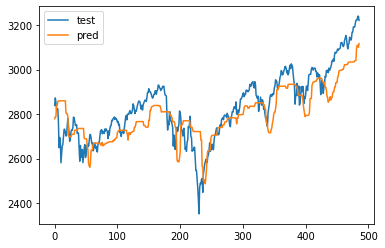

In [ ]:
# plot training history
plt.plot(y_test_regression, label='test')
plt.plot(y_pred_regression, label='pred')
plt.legend()
plt.show()

In [ ]:
import numpy as np
def MAPE(true, pred):
    diff = np.abs(np.array(true) - np.array(pred))
    return np.mean(diff / true)

In [ ]:
print(MAPE(y_test_regression,y_pred_regression))

0.053839655033216985


In [ ]:
##### HS300

from google.colab import files
uploaded = files.upload()

Saving hs300.csv to hs300 (1).csv


In [ ]:
import pandas as pd
import io

hs = pd.read_csv(io.StringIO(uploaded['hs300.csv'].decode('utf-8')))
hs

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,3535.2290,3592.4680,3597.7480,3535.2290,6610108000,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,15761101790,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,1/5/10,3564.0380,3545.1860,3577.5260,3497.6610,8580964100,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,15846911431,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,1/6/10,3541.7270,3558.7000,3588.8320,3541.1730,7847312500,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,15768438306,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,1/7/10,3471.4560,3543.1600,3558.5560,3452.7690,8035003700,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,15688088269,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,1/8/10,3480.1300,3456.9080,3482.0830,3426.6980,6079025300,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,15748878522,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2426,12/25/19,3990.8671,3988.6574,4000.5556,3976.3559,9493889000,3992.9581,3967.0962,4017.2527,3999.06,3991.66975,3931.248280,-0.2050,-0.0201,29.5162,4050.547309,3789.291191,59.0441,65.4477,2.4495,36.8824,-50.9325,95.4203,42.1334,67.250737,2.1166,1.426661,56.018210,58.590802,50.000000,41770235585,-0.0005,0.0006,0.5996,-0.002092,0.001468,0.018743,0.015165
2427,12/26/19,4025.9879,3993.6686,4025.9879,3993.5413,10886064000,3990.8671,3992.9581,3967.0962,3998.83,4005.16612,3939.432530,0.6791,0.5199,31.3967,4061.172471,3787.752475,60.6246,59.0441,3.2203,37.6992,-6.7947,125.6036,29.0058,24.967494,1.9755,1.571487,66.959028,63.912328,50.000000,41879096225,0.0088,0.0081,1.0000,-0.000058,0.002082,0.017191,0.021972
2428,12/27/19,4022.0278,4029.2454,4066.7964,4019.7223,15092641100,4025.9879,3990.8671,3992.9581,3999.79,4010.54679,3949.100390,0.5560,0.2863,32.1963,4070.493169,3788.618685,59.2181,60.6246,3.0563,39.1533,-5.1217,119.2786,39.6995,43.409408,1.8273,1.688829,64.778650,62.917741,50.000000,41728169814,-0.0010,-0.0018,0.0490,0.000239,0.002454,0.015321,0.018467
2429,12/30/19,4081.6334,4015.5195,4083.6901,4001.4951,15597148800,4022.0278,4025.9879,3990.8671,4022.69,4019.95549,3961.379115,1.4652,1.5343,37.2108,4087.226847,3789.703361,72.2409,59.2181,4.8987,43.6764,64.3807,190.6092,1.7136,1.713563,1.8678,1.855955,77.822341,70.464660,50.000000,41884141302,0.0148,0.0165,0.9750,0.005727,0.003109,0.018635,0.030357


In [ ]:
hs.dtypes

date                              object
close                            float64
open                             float64
high                             float64
low                              float64
volume                             int64
x(t-1)                           float64
x(t-2)                           float64
x(t-3)                           float64
MA5                              float64
MA10                             float64
MA20                             float64
BIAS5                            float64
BIAS10                           float64
DIFF                             float64
BU                               float64
BL                               float64
KDJ                              float64
KDJ(t-1)                         float64
ROC                              float64
TR（14）                           float64
MTM6                             float64
MTM12                            float64
WR%10                            float64
WR%5            

In [ ]:
hs[['volume']] = hs[['volume']].astype('float')
hs[['OBV']] = hs[['OBV']].astype('float')
hs_feature = hs
hs_feature = hs_feature.drop(['date'], axis=1)
hs_feature.head()

,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,3535.229,3592.468,3597.748,3535.229,6.610108e+09,3575.684,3575.680,3558.857,3529.79,3455.1185,3508.97380,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.412,-25.494,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,3564.038,3545.186,3577.526,3497.661,8.580964e+09,3535.229,3575.684,3575.684,3546.91,3471.8601,3503.73410,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.255,83.885,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,3541.727,3558.700,3588.832,3541.173,7.847312e+09,3564.038,3535.229,3575.684,3555.11,3495.4785,3499.61950,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.294,149.992,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,3471.456,3543.160,3558.556,3452.769,8.035004e+09,3541.727,3564.038,3535.229,3537.63,3508.9761,3495.46840,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.281,74.834,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,3480.130,3456.908,3482.083,3426.698,6.079025e+09,3471.456,3541.727,3564.038,3518.52,3513.1074,3490.61305,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.727,174.587,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003


In [ ]:
hs.iloc[:1944,:]

,date,close,open,high,low,volume,x(t-1),x(t-2),x(t-3),MA5,MA10,MA20,BIAS5,BIAS10,DIFF,BU,BL,KDJ,KDJ(t-1),ROC,TR（14）,MTM6,MTM12,WR%10,WR%5,OSC6,OSC12,RSI6,RSI12,PSY,OBV,return,(x(t)-xo(t))/xo(t),(x(t)-xl(t))/(xh(t)- xl(t)),(MA5(t)-MA5(t-1))/MA5(t-1),(MA20(t)-MA20(t-1))/MA20(t-1),(MA5(t)-MA20(t-1))/MA20(t-1),(x(t)-MA20(t))/MA20(t)
0,1/4/10,3535.2290,3592.4680,3597.7480,3535.2290,6.610108e+09,3575.6840,3575.6800,3558.8570,3529.79,3455.11850,3508.973800,0.1541,2.3186,-0.7398,3708.899235,3326.960919,77.7282,76.9618,-0.7160,66.1354,96.4120,-25.4940,20.7390,37.906844,-0.1607,-1.912190,58.214907,53.424573,66.666667,1.576110e+10,-0.0113,-0.0159,0.0000,0.006258,-0.003031,0.004383,0.007482
1,1/5/10,3564.0380,3545.1860,3577.5260,3497.6610,8.580964e+09,3535.2290,3575.6840,3575.6840,3546.91,3471.86010,3503.734100,0.4829,2.6550,4.4354,3708.705230,3341.118616,81.4247,77.7282,2.4104,68.8372,139.2550,83.8850,11.1824,22.999093,0.2994,-1.908078,63.228944,55.993992,75.000000,1.584691e+10,0.0081,0.0053,0.8311,0.004850,-0.001493,0.010811,0.017211
2,1/6/10,3541.7270,3558.7000,3588.8320,3541.1730,7.847312e+09,3564.0380,3535.2290,3575.6840,3555.11,3495.47850,3499.619500,-0.3764,1.3231,6.6597,3709.891699,3342.244301,80.3912,81.4247,4.4223,67.9544,63.2940,149.9920,18.5835,55.972304,0.5634,-1.574446,56.885306,53.500459,66.666667,1.576844e+10,-0.0063,-0.0048,0.0116,0.002311,-0.001174,0.014663,0.012032
3,1/7/10,3471.4560,3543.1600,3558.5560,3452.7690,8.035004e+09,3541.7270,3564.0380,3535.2290,3537.63,3508.97610,3495.468400,-1.8705,-1.0693,2.7208,3707.066967,3338.194033,64.4253,80.3912,2.2032,67.8967,-29.2810,74.8340,48.8652,87.110547,0.5234,-1.293455,41.245343,46.400698,66.666667,1.568809e+10,-0.0198,-0.0202,0.1766,-0.004917,-0.001186,0.010861,-0.006870
4,1/8/10,3480.1300,3456.9080,3482.0830,3426.6980,6.079025e+09,3471.4560,3541.7270,3564.0380,3518.52,3513.10740,3490.613050,-1.0910,-0.9387,0.2957,3700.756318,3335.489374,53.3627,64.4253,5.2816,65.1044,-78.7270,174.5870,62.8701,68.762350,0.2812,-0.742377,43.544489,47.341688,66.666667,1.574888e+10,0.0025,0.0067,0.9647,-0.005402,-0.001389,0.006595,-0.003003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1939,12/25/17,4041.5401,4057.4173,4086.9342,4026.4496,9.192696e+09,4054.5984,4067.8485,4030.4898,4045.96,4028.82140,4026.040530,-0.1093,0.3157,-0.0612,4177.429244,3927.683033,67.2614,69.9653,1.7749,52.4560,60.6843,70.4832,38.1463,44.895357,-0.4140,-0.557433,52.305887,50.817007,50.000000,3.909811e+10,-0.0032,-0.0039,0.2495,0.002788,-0.000104,0.004843,0.003850
1940,12/26/17,4053.6224,4040.6173,4056.8554,4015.2996,9.111879e+09,4041.5401,4054.5984,4067.8485,4049.62,4032.58201,4025.930475,0.0988,0.5218,1.3843,4168.516541,3929.656429,68.8432,67.2614,1.2550,50.0413,68.3310,50.2432,27.9931,46.086141,-0.0457,-0.367066,56.427674,52.678053,50.000000,3.918923e+10,0.0030,0.0032,0.9222,0.000904,-0.000027,0.005857,0.006878
1941,12/27/17,3991.2075,4045.2793,4047.7366,3986.7385,1.051536e+10,4053.6224,4041.5401,4054.5984,4041.76,4026.69349,4022.803205,-1.2508,-0.8813,-2.4779,4140.880740,3939.869614,52.4146,68.8432,-1.9239,50.3936,-44.1219,-78.2922,80.4427,95.539729,-0.0121,-0.313364,36.743384,43.419306,50.000000,3.908408e+10,-0.0154,-0.0134,0.0733,-0.001940,-0.000777,0.003932,-0.007854
1942,12/28/17,4018.8974,3992.9970,4036.6975,3980.2358,1.185429e+10,3991.2075,4053.6224,4041.5401,4031.97,4025.96807,4023.443110,-0.3243,-0.1756,-3.2667,4099.608793,3965.090084,49.2184,52.4146,0.0717,50.2338,-11.5924,2.8811,57.1738,63.765530,0.1388,-0.108135,46.650982,47.854955,50.000000,3.920262e+10,0.0069,0.0065,0.6847,-0.002422,0.000159,0.002279,-0.001130


In [ ]:
hs_train = hs_feature.iloc[:1944, :]
hs_test = hs_feature.iloc[1944:, :]
print(hs_train.shape, hs_test.shape)

(1944, 37) (487, 37)


In [ ]:
# 一阶差分
scaler = MinMaxScaler(feature_range = (0,1))
hs_train = scaler.fit_transform(hs_train)
hs_test = scaler.transform(hs_test)

In [ ]:
y_train_hs = np.array(hs_feature.iloc[:1944, 0])
y_test_hs = np.array(hs_feature.iloc[1944:, 0])
print(y_train_hs.shape, y_test_hs.shape)

(1944,) (487,)


In [ ]:
past_steps = 10
next_steps = 3

In [ ]:
X_train_hs = np.array([hs_train[i : i + past_steps, :] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
X_test_hs = np.array([hs_test[i : i + past_steps, :] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
y_train_regression_hs = np.array([y_train_hs[i + past_steps + next_steps] for i in range(0, hs_train.shape[0] - (next_steps+ past_steps),1)])
y_test_regression_hs = np.array([y_test_hs[i + past_steps + next_steps] for i in range(0, hs_test.shape[0] - (next_steps+ past_steps),1)])

In [ ]:
def LSTM_fun_keras_att(n_input,train_x,train_y,predict_x,prediction_y,seq_len=5):
    tf.compat.v1.keras.backend.get_session().close()
    tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session())
    tf.compat.v1.keras.backend.get_session().run(tf.compat.v1.global_variables_initializer())
    inputs = Input(shape=(seq_len, n_input))
    #drop1 = Dropout(0.3)(inputs)
    x = Conv1D(filters = 32, kernel_size = 1, activation = 'relu')(inputs)  #, padding = 'same'
    #x = Conv1D(filters=128, kernel_size=5, activation='relu')(output1)#embedded_sequences
    x = MaxPooling1D(pool_size = past_steps)(x)
    x = Dropout(0.1)(x)
    print(x.shape)
    lstm_out = Bidirectional(LSTM(32, activation='relu'), name='bilstm')(x)
    #lstm_out = LSTM(lstm_units,activation='relu')(x)
    print(lstm_out.shape)
    # ATTENTION PART STARTS HERE
    attention_probs = Dense(64, activation='sigmoid', name='attention_vec')(lstm_out)
    #attention_mul=layers.merge([stm_out,attention_probs], output_shape],mode='concat',concat_axis=1))
    attention_mul =Multiply()([lstm_out, attention_probs])
    #attention_mul = merge([lstm_out, attention_probs],output_shape=32, name='attention_mul', mode='mul')
    output = Dense(1, activation='linear')(attention_mul)
    #output = Dense(10, activation='sigmoid')(drop2)

    model = Model(inputs=inputs, outputs=output)
    print(model.summary())
    model.compile(loss='mse', optimizer='adam')
    #model_class.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    # simple early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
    # fit model
    history = model.fit(train_x, train_y,validation_split=0.1, epochs=epochs, batch_size=1, shuffle=False, verbose=2, callbacks=[es])
    #history = model.fit(train_x, train_y, epochs=100, batch_size=1, shuffle=False)
    y_pred = model.predict(predict_x)
    return y_pred

In [ ]:
y_pred_regression_hs = LSTM_fun_keras_att(INPUT_DIM, X_train_hs, y_train_regression_hs, X_test_hs, y_test_regression_hs, seq_len=past_steps)

(None, 1, 32)
(None, 64)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 37)]     0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 32)       1216        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 1, 32)        0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1, 32)        0           max_pooling1d_1[0][0]            
______________________________________________________________

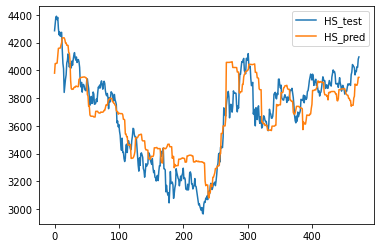

In [ ]:
# plot training history
plt.plot(y_test_regression_hs, label='HS_test')
plt.plot(y_pred_regression_hs, label='HS_pred')
plt.legend()
plt.show()

In [ ]:
print(MAPE(y_test_regression_hs,y_pred_regression_hs))

0.09355762578929477
